In [29]:
from json import load
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.ndimage import label

DIRPATH = './maps/example_maps_v3'
MAP_001 = 'map_20250124_213956_876504.json'
ESTIMATED_COLOR = 200

colormap = {
    -1: [0.5, 0.5, 0.5],  # Gray (unknown terrain)
    0: [1.0, 1.0, 1.0],  # White (blank space)
    100: [0.0, 0.0, 0.0],  # Black (walls)
    ESTIMATED_COLOR: [0.0, 1.0, 0.0]  # Green (estimated walls)
}

val_free = 0
val_occupied = 100
val_unknown = -1

In [16]:
def read_data(_dir_path: str=DIRPATH, _map_path: str=MAP_001) -> tuple[np.ndarray[tuple[()], np.dtype], int, int]:
    _data = dict()
    with open(_dir_path + '/' + _map_path, 'r+') as json_data:
        _data = load(json_data)
        json_data.close()
        
    print(_data)

    width = _data['info']['width']
    height = _data['info']['height']
    _data = _data['data']

    grid = np.array(_data).reshape((height, width))

    return grid, height, width

def print_plot(grid: np.ndarray[tuple[()], np.dtype], height: int, width: int) -> None:
    colored_map = np.zeros((height, width, 3))
    for y in range(height):
        for x in range(width):
            color_code = grid[y, x]
            colored_map[y, x] = colormap[color_code]
            
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(colored_map, origin='upper')
    plt.title("Original map")
    plt.axis('off')
    
    return

{'header': {'stamp': {'sec': 856, 'nanosec': 791000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 152, 'height': 181, 'origin': {'position': {'x': -6.114853446801852, 'y': -5.0964407954364, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

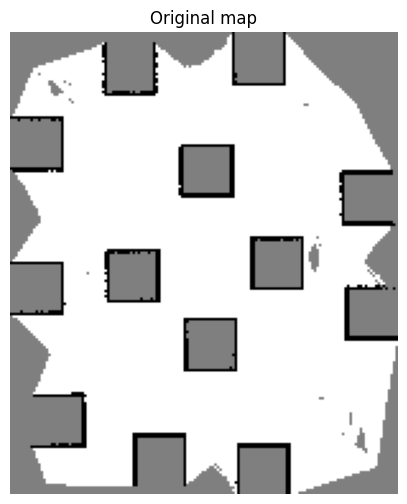

In [18]:
print(*read_data())

print_plot(*read_data())

In [27]:
def fill_enclosed_unknowns(grid: np.ndarray) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    # Identify all accessible -1 regions using flood fill from edges
    accessible = np.zeros_like(grid, dtype=bool)
    queue = []
    
    # Start flood fill from the borders where -1 is found
    for i in range(height):
        if grid[i, 0] == -1:
            queue.append((i, 0))
        if grid[i, width - 1] == -1:
            queue.append((i, width - 1))
    for j in range(width):
        if grid[0, j] == -1:
            queue.append((0, j))
        if grid[height - 1, j] == -1:
            queue.append((height - 1, j))
    
    while queue:
        x, y = queue.pop()
        if accessible[x, y] or grid[x, y] != -1:
            continue
        accessible[x, y] = True
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < height and 0 <= ny < width and grid[nx, ny] == -1:
                queue.append((nx, ny))
    
    # Any -1 not marked as accessible is enclosed and should be converted to 100
    filled_grid[(grid == -1) & (~accessible)] = 100
    
    return filled_grid

{'header': {'stamp': {'sec': 856, 'nanosec': 791000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 152, 'height': 181, 'origin': {'position': {'x': -6.114853446801852, 'y': -5.0964407954364, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

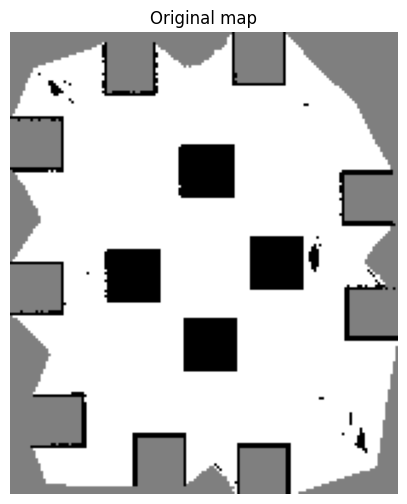

In [28]:
_grid, _height, _width = read_data()
_grid = fill_enclosed_unknowns(_grid)

print_plot(_grid, _height, _width)

In [37]:
def calculate_remaining_space(grid: np.ndarray[tuple[()], np.dtype]) -> None:

    _explored_num = np.count_nonzero(grid==100) + np.count_nonzero(grid==0)
    print(_width, _height, _width*_height, _explored_num)
    _explored_percent = _explored_num / (_width * _height)
    print('explored %f not explored %f', _explored_percent, 1.0-_explored_percent)
    
    return

calculate_remaining_space(grid=_grid)

152 181 27512 20353
explored %f not explored %f 0.7397862750799651 0.2602137249200349


152 181 27512 23
explored %f not explored %f 0.0008359988368711835 0.9991640011631289


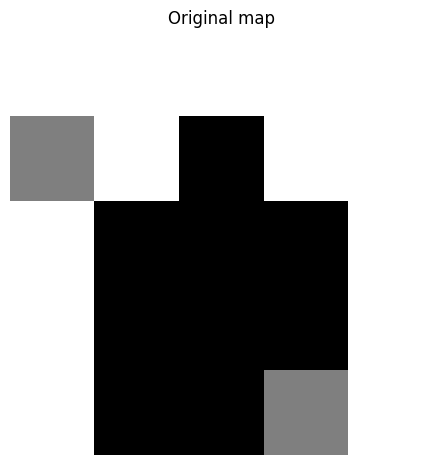

In [39]:
test_grid = np.array([
    [0,   0,    0,    0, 0],
    [-1, 0, 100, 0, 0],
    [0, 100,  -1 , 100, 0],
    [0, 100, -1  , 100, 0],
    [0, 100, 100, -1, 0]
])
test_grid = fill_enclosed_unknowns(test_grid)
print_plot(test_grid, 5, 5)

calculate_remaining_space(grid=test_grid)

In [ ]:
def fill_boundary_gaps(grid: np.ndarray) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if grid[i, j] == -1:
                # Check horizontal filling condition
                if grid[i, j - 1] == 100 and grid[i, j + 1] == 100:
                    filled_grid[i, j] = 100
                # Check vertical filling condition
                elif grid[i - 1, j] == 100 and grid[i + 1, j] == 100:
                    filled_grid[i, j] = 100
    
    return filled_grid


def fill_boundary_unknowns(grid: np.ndarray, max_range: int = 5) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    for i in range(height):
        for j in range(width):
            if grid[i, j] == -1:
                # Check if within max_range from an occupied boundary
                for dx in range(-max_range, max_range + 1):
                    for dy in range(-max_range, max_range + 1):
                        ni, nj = i + dx, j + dy
                        if 0 <= ni < height and 0 <= nj < width and grid[ni, nj] == 100:
                            filled_grid[i, j] = 100
                            break
                    if filled_grid[i, j] == 100:
                        break
    return filled_grid

In [43]:
test_grid = np.array([
    [0,   0,    0,    0, 0],
    [-1, 0, 100, 100, 0],
    [0, 100,  -1 , -1, 0],
    [0, 100, -1  , 100, 0],
    [0, 100, 100, -1, 0]
])

print(fill_boundary_gaps(test_grid))

[[  0   0   0   0   0]
 [ -1   0 100 100   0]
 [  0 100  -1 100   0]
 [  0 100 100 100   0]
 [  0 100 100  -1   0]]
